<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


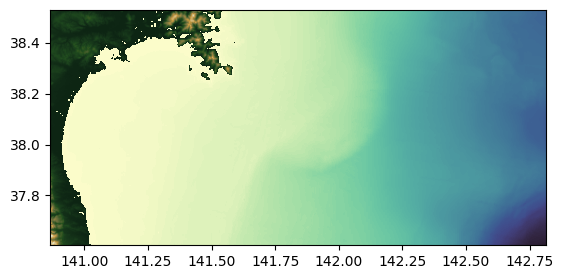

In [1]:
import rasterio
from matplotlib import colors
import cmocean
import numpy as np
import probnum as pn
import linpde_gp
from rasterio.plot import show

# Specify the path to your GeoTIFF file
tif_path = "./data/27-11-23_sendai_coast_v3.tif"

# Open the GeoTIFF file
with rasterio.open(tif_path) as src:
    # Read the raster data into a NumPy array
    raster_array = src.read(1)  # Assuming a single band, adjust the index if you have multiple bands
    divnorm=colors.TwoSlopeNorm(vmin=raster_array.min(), vcenter=0., vmax=raster_array.max())
    ax = show(src, cmap=cmocean.cm.topo, norm=divnorm)
    bounds = src.bounds
    # Get coordinate array
    cols, rows = np.meshgrid(np.arange(src.width), np.arange(src.height))
    lons, lats = rasterio.transform.xy(src.transform, rows, cols)
    lons = np.array(lons)
    lats = np.array(lats)

lon_start = bounds.left
lon_end = bounds.right
lat_start = bounds.bottom
lat_end = bounds.top

earthquake_epicenter = (142.516, 38.062)  # (longitude, latitude)

dists = np.sqrt((lons - earthquake_epicenter[0])**2 + (lats - earthquake_epicenter[1])**2)
epicenter_idx = np.argwhere(dists == dists.min())[0]

raster_array_flipped = raster_array[::-1, :]

# Plot the epicenter
ax.scatter(epicenter_idx[0], epicenter_idx[1], s=100, c='r', marker='x')

In [2]:
km_per_lat = 111.32
km_per_lon = km_per_lat * np.cos(np.radians((lat_start + lat_end) / 2))
print(f"km per lat: {km_per_lat:.2f}km, km per lon: {km_per_lon:.2f}km")

dist_x = (lons[-1, -1] - lon_start) * km_per_lon
dist_y = (lat_end - lats[-1, -1]) * km_per_lat
print(f"dist_x: {dist_x:.2f}km, dist_y: {dist_y:.2f}km")

km per lat: 111.32km, km per lon: 87.64km
dist_x: 170.72km, dist_y: 102.74km


In [3]:
earthquake_epicenter_coords_km = (earthquake_epicenter[0] - lon_start) * km_per_lon, (earthquake_epicenter[1] - lat_start) * km_per_lat
print(f"earthquake epicenter coordinates (km): {earthquake_epicenter_coords_km[0]:.2f}km, {earthquake_epicenter_coords_km[1]:.2f}km")

mean = np.array(earthquake_epicenter_coords_km)
cov = np.array([[20, 0], [0, 300]])
scaling_factor = 5

def gaussian_bump_2d(X, mean, cov, scaling_factor=1.):
    """Compute a 2D Gaussian bump at the given mean and covariance."""
    inv = np.linalg.inv(cov)
    X_tilde = X - mean
    return scaling_factor * np.exp(-0.5 * (X_tilde[..., None, :] @ (inv @ X_tilde[..., None]))[..., 0, 0])

earthquake epicenter coordinates (km): 144.55km, 50.97km


In [4]:
import linpde_gp
DURATION = 30 * 60 # seconds

domain = linpde_gp.domains.Box([[0., DURATION], [0., dist_x], [0., dist_y]]) # time, x, y

In [5]:
N_ic = 50
X_ic = domain.uniform_grid((1, N_ic, N_ic))
Y_ic = gaussian_bump_2d(X_ic[..., 1:], mean, cov, scaling_factor=scaling_factor)

In [6]:
from linpde_gp.randprocs.covfuncs import IndependentMultiOutputCovarianceFunction, TensorProduct, Matern

prior_mean = linpde_gp.functions.StackedFunction(
    (
        linpde_gp.functions.Constant((3,), 0.),
        linpde_gp.functions.Constant((3,), 0.),
        linpde_gp.functions.Constant((3,), 0.),
    )
)

lengthscale_t = DURATION / 100
lengthscale_x = (dist_x * 1000) / 30
lengthscale_y = (dist_y * 1000) / 30

lengthscales = np.array([lengthscale_t, lengthscale_x, lengthscale_y])

def get_tensor_product(lengthscales):
    return TensorProduct(
            Matern((), nu=2.5, lengthscales=lengthscales[0]),
            Matern((), nu=2.5, lengthscales=lengthscales[1]),
            Matern((), nu=2.5, lengthscales=lengthscales[2]),
        )

def get_prior(lengthscales):
    prior_cov = IndependentMultiOutputCovarianceFunction(
        get_tensor_product(lengthscales),
        get_tensor_product(lengthscales),
        get_tensor_product(lengthscales),
    )
    return pn.randprocs.GaussianProcess(mean=prior_mean, cov=prior_cov)

u_prior = get_prior(lengthscales)
u_prior.std(np.array([0., 0., 0.]))

array([1., 1., 1.])

In [27]:
# Create a meshgrid of the latitudes and longitudes
N_ic = 50
lats_initial = np.linspace(0, dist_y, N_ic)
lons_initial = np.linspace(0, dist_x, N_ic)

lon_mesh, lat_mesh = np.meshgrid(lons_initial, lats_initial, indexing='ij')
X = np.stack((lon_mesh, lat_mesh), axis=-1)
X.shape

(50, 50, 2)

In [8]:
gaussian_bump_2d(X, mean, cov).shape

(50, 50)

In [9]:
X.shape

(50, 50, 2)

In [10]:
raster_array_flipped.T.shape

(468, 222)

In [11]:
lons.shape

(222, 468)

In [28]:
kms_lon = (lons - lon_start) * km_per_lon
kms_lat = (lats - lat_start) * km_per_lat

def closest_idx(x: np.ndarray):
    dists = np.sqrt((kms_lon - x[0])**2 + (kms_lat - x[1])**2)
    dists_flat = dists.flatten()
    flat_idx = np.argmin(dists_flat)
    return np.unravel_index(flat_idx, dists.shape)

def bathymetry_vals(X: np.ndarray):
    X_flat = X.reshape(-1, 2)
    idxs = np.array([closest_idx(x) for x in X_flat])
    return raster_array_flipped[idxs[..., 0], idxs[..., 1]].reshape(X.shape[:-1])

bathymetry_vals(X)

array([[   66,    44,    47, ...,   538,   259,   444],
       [   22,    28,    77, ...,   122,   120,   153],
       [   22,    70,    31, ...,    30,    43,    54],
       ...,
       [-1416, -1423, -1441, ..., -2004, -2087, -2136],
       [-1468, -1473, -1478, ..., -2122, -2160, -2200],
       [-1503, -1502, -1496, ..., -2138, -2180, -2278]], dtype=int16)

In [21]:
kms_lon[221, 0], kms_lat[221, 0]

(0.182586569017167, 0.2319166666672467)

In [22]:
kms_lon[0, 0], kms_lat[221, 0]

(0.182586569017167, 0.2319166666672467)

In [23]:
lat_end, lat_start, lon_end, lon_start

(38.52916666666667, 37.604166666666664, 142.81666666666663, 140.86666666666665)

In [24]:
X[0, 0]

array([0., 0.])

In [25]:
lons[221, 0], lats[221, 0]

(140.86874999999998, 37.60625)

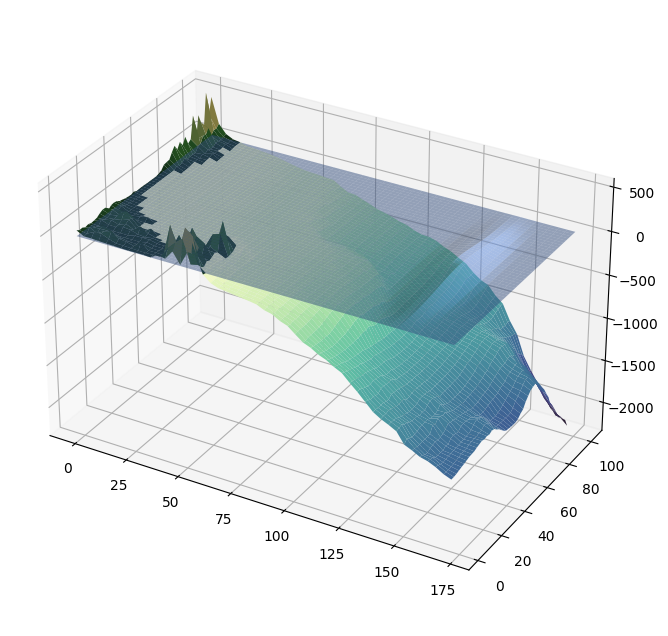

In [29]:
# 3D plot of elevation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import numpy as np

lon_mesh, lat_mesh = np.meshgrid(lons, lats, indexing='ij')

# Plot the meshgrid and the elevation data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X[..., 0], X[..., 1], bathymetry_vals(X), cmap=cmocean.cm.topo, norm=divnorm)

# Plot epicenter point
ax.plot_surface(X[..., 0], X[..., 1], gaussian_bump_2d(X, mean, cov, scaling_factor=100.), alpha=0.5, color='cornflowerblue')
# # ax.set_zlim(-120, 50)
# # Rotate viewpoint
# ax.view_init(azim=45)
ax.set_box_aspect([dist_x / dist_y, 1, 1])

# Required resolution

In [114]:
# Depth around where the epicenter is
raster_array[:, -20].mean()

-1491.3963963963963

In [123]:
# Propagation speed of tsunami
mps = np.sqrt(9.81 * 1500)
kmps = mps / 1000
kmpm = kmps * 60
kmph = kmpm * 60
kmph

436.6994389737637

In [135]:
# Time it takes for tsunami to reach Sendai without slowdowns
distance = 130
time = distance / kmph
time * 60 # minutes

17.86125491328743

In reality, it took about half an hour. But note that we did not include slowdown due to the coast run-up in our calculation.

In [125]:
pixel_extent / 1000

0.46305

In [132]:
ppm = (pixel_extent / 1000) * kmpm
ppm

3.3702279202800214

In [133]:
ppm * 30

101.10683760840064

In [169]:
lons, lats

(array([[140.86875   , 140.87291667, 140.87708333, ..., 142.80625   ,
         142.81041667, 142.81458333],
        [140.86875   , 140.87291667, 140.87708333, ..., 142.80625   ,
         142.81041667, 142.81458333],
        [140.86875   , 140.87291667, 140.87708333, ..., 142.80625   ,
         142.81041667, 142.81458333],
        ...,
        [140.86875   , 140.87291667, 140.87708333, ..., 142.80625   ,
         142.81041667, 142.81458333],
        [140.86875   , 140.87291667, 140.87708333, ..., 142.80625   ,
         142.81041667, 142.81458333],
        [140.86875   , 140.87291667, 140.87708333, ..., 142.80625   ,
         142.81041667, 142.81458333]]),
 array([[38.52708333, 38.52708333, 38.52708333, ..., 38.52708333,
         38.52708333, 38.52708333],
        [38.52291667, 38.52291667, 38.52291667, ..., 38.52291667,
         38.52291667, 38.52291667],
        [38.51875   , 38.51875   , 38.51875   , ..., 38.51875   ,
         38.51875   , 38.51875   ],
        ...,
        [37.614583

In [171]:
lats.shape

(222, 468)

In [179]:
km_per_lat = 111.32
km_per_lon = km_per_lat * np.cos(np.radians((lat_start + lat_end) / 2))
km_per_lat, km_per_lon

(111.32, 87.64155312831987)

In [183]:
lats[-1, -1]

37.60625

In [185]:
lat_end

38.52916666666667

In [176]:
lon_start

140.86666666666665